### Setup of a two-qubit chip with $C^3$

In this example we will set-up a two qubit quantum processor and define a simple gate.

#### Imports

In [1]:
# System imports
import copy
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

# Main C3 objects
from c3po.c3objs import Quantity as Qty
from c3po.experiment import Experiment as Exp
from c3po.system.model import Model as Mdl
from c3po.generator.generator import Generator as Gnr

# Building blocks
import c3po.generator.devices as devices
import c3po.signal.gates as gates
import c3po.system.chip as chip
import c3po.signal.pulse as pulse
import c3po.system.tasks as tasks

# Libs and helpers
import c3po.libraries.algorithms as algorithms
import c3po.libraries.hamiltonians as hamiltonians
import c3po.libraries.fidelities as fidelities
import c3po.libraries.envelopes as envelopes
import c3po.utils.qt_utils as qt_utils
import c3po.utils.tf_utils as tf_utils

#### Model components
We first create a qubit. Each parameter is a Quantity (Qty()) object with bounds and a unit. In $C^3$, the default multi-level qubit is a Transmon modelled as a Duffing oscillator with frequency $\omega$ and anharmonicity $\delta$ :
$$ H/\hbar = \omega b^\dagger b - \frac{\delta}{2}                        \left(b^\dagger b - 1\right) b^\dagger b 
$$
The "name" will be used to identify this qubit (or other component) later and should thus be chosen carefully.

In [2]:
qubit_lvls = 3
freq_q1 = 5e9 * 2 * np.pi
anhar_q1 = -210e6 * 2 * np.pi
t1_q1 = 27e-6
t2star_q1 = 39e-6
qubit_temp = 50e-3

q1 = chip.Qubit(
    name="Q1",
    desc="Qubit 1",
    freq=Qty(
        value=freq_q1,
        min=4.995e9 * 2 * np.pi,
        max=5.005e9 * 2 * np.pi,
        unit='Hz 2pi'
    ),
    anhar=Qty(
        value=anhar_q1,
        min=-380e6 * 2 * np.pi,
        max=-120e6 * 2 * np.pi,
        unit='Hz 2pi'
    ),
    hilbert_dim=qubit_lvls,
    t1=Qty(
        value=t1_q1,
        min=1e-6,
        max=90e-6,
        unit='s'
    ),
    t2star=Qty(
        value=t2star_q1,
        min=10e-6,
        max=90e-3,
        unit='s'
    ),
    temp=Qty(
        value=qubit_temp,
        min=0.0,
        max=0.12,
        unit='K'
    )
)

And the same for a second qubit.

In [3]:
freq_q2 = 5.6e9 * 2 * np.pi
anhar_q2 = -240e6 * 2 * np.pi
t1_q2 = 23e-6
t2star_q2 = 31e-6
q2 = chip.Qubit(
    name="Q2",
    desc="Qubit 2",
    freq=Qty(
        value=freq_q2,
        min=5.595e9 * 2 * np.pi,
        max=5.605e9 * 2 * np.pi,
        unit='Hz 2pi'
    ),
    anhar=Qty(
        value=anhar_q2,
        min=-380e6 * 2 * np.pi,
        max=-120e6 * 2 * np.pi,
        unit='Hz 2pi'
    ),
    hilbert_dim=qubit_lvls,
    t1=Qty(
        value=t1_q2,
        min=1e-6,
        max=90e-6,
        unit='s'
    ),
    t2star=Qty(
        value=t2star_q2,
        min=10e-6,
        max=90e-6,
        unit='s'
    ),
    temp=Qty(
        value=qubit_temp,
        min=0.0,
        max=0.12,
        unit='K'
    )
)

A static coupling between the two is realized in the following way. We supply the type of coupling by selecting int_XX $(b_1+b_1^\dagger)(b_2+b_2^\dagger)$ from the hamiltonian library. The "connected" property contains the list of qubit names to be coupled, in this case "Q1" and "Q2".

In [4]:
coupling_strength = 20e6 * 2 * np.pi
q1q2 = chip.Coupling(
    name="Q1-Q2",
    desc="coupling",
    comment="Coupling qubit 1 to qubit 2",
    connected=["Q1", "Q2"],
    strength=Qty(
        value=coupling_strength,
        min=-1 * 1e3 * 2 * np.pi,
        max=200e6 * 2 * np.pi,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.int_XX
)

In the same spirit, we specify control Hamiltonians to drive the system. Again "connected" connected tells us which qubit this drive acts on and "name" will later be used to assign the correct control signal to this drive line.

In [5]:
drive = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive
)
drive2 = chip.Drive(
    name="d2",
    desc="Drive 2",
    comment="Drive line 2 on qubit 2",
    connected=["Q2"],
    hamiltonian_func=hamiltonians.x_drive
)

#### SPAM errors
In experimental practice, the qubit state can be mis-classified during read-out. We simulate this by constructing a _confusion matrix_, containing the probabilities for one qubit state being mistaken for another.

In [6]:
m00_q1 = 0.97 # Prop to read qubit 1 state 0 as 0
m01_q1 = 0.04 # Prop to read qubit 1 state 0 as 1
m00_q2 = 0.96 # Prop to read qubit 2 state 0 as 0
m01_q2 = 0.05 # Prop to read qubit 2 state 0 as 1
one_zeros = np.array([0] * qubit_lvls)
zero_ones = np.array([1] * qubit_lvls)
one_zeros[0] = 1
zero_ones[0] = 0
val1 = one_zeros * m00_q1 + zero_ones * m01_q1
val2 = one_zeros * m00_q2 + zero_ones * m01_q2
min = one_zeros * 0.8 + zero_ones * 0.0
max = one_zeros * 1.0 + zero_ones * 0.2
confusion_row1 = Qty(value=val1, min=min, max=max, unit="")
confusion_row2 = Qty(value=val2, min=min, max=max, unit="")
conf_matrix = tasks.ConfusionMatrix(Q1=confusion_row1, Q2=confusion_row2)

The following task creates an initial thermal state with given temperature.

In [7]:
init_temp = 50e-3
init_ground = tasks.InitialiseGround(
    init_temp=Qty(
        value=init_temp,
        min=-0.001,
        max=0.22,
        unit='K'
    )
)

We collect the parts specified above in the Model.

In [8]:
model = Mdl(
    [q1, q2], # Individual, self-contained components
    [drive, drive2, q1q2],  # Interactions between components
    [conf_matrix, init_ground] # SPAM processing
)

Further, we can decide between coherent or open-system dynamics using set_lindbladian() and whether to eliminate the static coupling by going to the dressed frame with set_dressed().

In [9]:
model.set_lindbladian(False)
model.set_dressed(True)

#### Control signals
With the system model taken care of, we now specify the control electronics and signal chain. Complex shaped controls are often realized by creating an envelope signal with an arbitrary waveform generator (AWG) with limited bandwith and mixing it with a fast, stable local oscillator (LO).

In [10]:
sim_res = 100e9 # Resolution for numerical simulation
awg_res = 2e9 # Realistic, limited resolution of an AWG
lo = devices.LO(name='lo', resolution=sim_res)
awg = devices.AWG(name='awg', resolution=awg_res)
mixer = devices.Mixer(name='mixer')

Waveform generators exhibit a rise time, the time it takes until the target voltage is set. This has a smoothing effect on the resulting pulse shape.

In [11]:
resp = devices.Response(
    name='resp',
    rise_time=Qty(
        value=0.3e-9,
        min=0.05e-9,
        max=0.6e-9,
        unit='s'
    ),
    resolution=sim_res
)

In simulation, we translate between AWG resolution and simulation (or "analog") resolultion by including an up-sampling device.

In [12]:
dig_to_an = devices.Digital_to_Analog(
    name="dac",
    resolution=sim_res
)

Control electronics apply voltages to lines, whereas in a Hamiltonian we usually write the control fields in energy or frequency units. In practice, this conversion can be highly non-trivial if it involves multiple stages of attenuation and for example the conversion of a line voltage in an antenna to a dipole field coupling to the qubit. The following device represents a simple, linear conversion factor.

In [13]:
v2hz = 1e9
v_to_hz = devices.Volts_to_Hertz(
    name='v_to_hz',
    V_to_Hz=Qty(
        value=v2hz,
        min=0.9e9,
        max=1.1e9,
        unit='Hz 2pi/V'
    )
)

The generator combines the parts of the signal generation.

In [14]:
generator = Gnr([lo, awg, mixer, v_to_hz, dig_to_an, resp])

#### Gates-set
It remains to write down what kind of operations we want to perform on the device. For a gate based quantum computing chip, we define a gate-set.

In [15]:
gateset = gates.GateSet()

We choose a gate time and a gaussian envelope shape with a list of parameters.

In [16]:
t_final = 7e-9   # Time for single qubit gates
sideband = 50e6 * 2 * np.pi
gauss_params_single = {
    'amp': Qty(
        value=0.5,
        min=0.4,
        max=0.6,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min=0.5 * t_final,
        max=1.5 * t_final,
        unit="s"
    ),
    'sigma': Qty(
        value=t_final / 4,
        min=t_final / 8,
        max=t_final / 2,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min=-0.5 * np.pi,
        max=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 3e6 * 2 * np.pi,
        min=-56 * 1e6 * 2 * np.pi,
        max=-52 * 1e6 * 2 * np.pi,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=0,
        min=-5,
        max=3,
        unit=""
    )
}

Here we take gaussian_nonorm() from the libraries as the function to define the shape.

In [17]:
gauss_env_single = pulse.Envelope(
    name="gauss",
    desc="Gaussian comp for single-qubit gates",
    params=gauss_params_single,
    shape=envelopes.gaussian_nonorm
)

We also define a gate that represents no driving.

In [18]:
nodrive_env = pulse.Envelope(
    name="no_drive",
    params={
        't_final': Qty(
            value=t_final,
            min=0.5 * t_final,
            max=1.5 * t_final,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)

We specify the drive tones with an offset from the qubit frequencies. As in experiment, we will later adjust the resonance by modulating the envelope function.

In [19]:
lo_freq_q1 = 5e9 * 2 * np.pi + sideband
carrier_parameters = {
    'freq': Qty(
        value=lo_freq_q1,
        min=4.5e9 * 2 * np.pi,
        max=6e9 * 2 * np.pi,
        unit='Hz 2pi'
    ),
    'framechange': Qty(
        value=0.0,
        min= -np.pi,
        max= 3 * np.pi,
        unit='rad'
    )
}
carr = pulse.Carrier(
    name="carrier",
    desc="Frequency of the local oscillator",
    params=carrier_parameters
)

For the second qubit drive tone, we copy the first one and replace the frequency. The deepcopy is to ensure that we don't just create a pointer to the first drive.

In [20]:
lo_freq_q2 = 5.6e9 * 2 * np.pi + sideband
carr_2 = copy.deepcopy(carr)
carr_2.params['freq'].set_value(lo_freq_q2)

#### Instructions
We define the gates we want to perform with a "name" that will identify them later and "channels" relating to the control Hamiltonians and drive lines we specified earlier. As a start we write down 90 degree rotations in the positive $x$-direction and identity gates for both qubits. Then we add a carrier and envelope to each.

In [21]:
X90p_q1 = gates.Instruction(
    name="X90p",
    t_start=0.0,
    t_end=t_final,
    channels=["d1"]
)
X90p_q2 = gates.Instruction(
    name="X90p",
    t_start=0.0,
    t_end=t_final,
    channels=["d2"]
)
QId_q1 = gates.Instruction(
    name="Id",
    t_start=0.0,
    t_end=t_final,
    channels=["d1"]
)
QId_q2 = gates.Instruction(
    name="Id",
    t_start=0.0,
    t_end=t_final,
    channels=["d2"]
)

X90p_q1.add_component(gauss_env_single, "d1")
X90p_q1.add_component(carr, "d1")
QId_q1.add_component(nodrive_env, "d1")
QId_q1.add_component(copy.deepcopy(carr), "d1")

X90p_q2.add_component(copy.deepcopy(gauss_env_single), "d2")
X90p_q2.add_component(carr_2, "d2")
QId_q2.add_component(copy.deepcopy(nodrive_env), "d2")
QId_q2.add_component(copy.deepcopy(carr_2), "d2")

When later compiling gates into sequences, we have to take care of the relative rotating frames of the qubits and local oscillators. We do this by adding a phase after each gate that realigns the frames.

In [22]:
QId_q1.comps['d1']['carrier'].params['framechange'].set_value(
    (-sideband * t_final) % (2*np.pi)
)
QId_q2.comps['d2']['carrier'].params['framechange'].set_value(
    (-sideband * t_final) % (2*np.pi)
)

The remainder of the gates-set can be derived from the X90p gate by shifting its phase by multiples of $\pi/2$.

In [23]:
Y90p_q1 = copy.deepcopy(X90p_q1)
Y90p_q1.name = "Y90p"
X90m_q1 = copy.deepcopy(X90p_q1)
X90m_q1.name = "X90m"
Y90m_q1 = copy.deepcopy(X90p_q1)
Y90m_q1.name = "Y90m"
Y90p_q1.comps['d1']['gauss'].params['xy_angle'].set_value(0.5 * np.pi)
X90m_q1.comps['d1']['gauss'].params['xy_angle'].set_value(np.pi)
Y90m_q1.comps['d1']['gauss'].params['xy_angle'].set_value(1.5 * np.pi)
Q1_gates = [QId_q1, X90p_q1, Y90p_q1, X90m_q1, Y90m_q1]


Y90p_q2 = copy.deepcopy(X90p_q2)
Y90p_q2.name = "Y90p"
X90m_q2 = copy.deepcopy(X90p_q2)
X90m_q2.name = "X90m"
Y90m_q2 = copy.deepcopy(X90p_q2)
Y90m_q2.name = "Y90m"
Y90p_q2.comps['d2']['gauss'].params['xy_angle'].set_value(0.5 * np.pi)
X90m_q2.comps['d2']['gauss'].params['xy_angle'].set_value(np.pi)
Y90m_q2.comps['d2']['gauss'].params['xy_angle'].set_value(1.5 * np.pi)
Q2_gates = [QId_q2, X90p_q2, Y90p_q2, X90m_q2, Y90m_q2]

With the single qubit gates in place, we can combine them to get all possible combinations of simultaneous gates on both qubits.

In [24]:
all_1q_gates_comb = []
for g1 in Q1_gates:
    for g2 in Q2_gates:
        g = gates.Instruction(
            name="NONE",
            t_start=0.0,
            t_end=t_final,
            channels=[]
        )
        g.name = g1.name + ":" + g2.name
        channels = []
        channels.extend(g1.comps.keys())
        channels.extend(g2.comps.keys())
        for chan in channels:
            g.comps[chan] = {}
            if chan in g1.comps:
                g.comps[chan].update(g1.comps[chan])
            if chan in g2.comps:
                g.comps[chan].update(g2.comps[chan])
        all_1q_gates_comb.append(g)

for gate in all_1q_gates_comb:
    gateset.add_instruction(gate)

#### The experiment
Finally everything is collected in the experiment that provides the functions to interact with the system.

In [25]:
exp = Exp(model=model, generator=generator, gateset=gateset)

#### Simulation
With our experiment all set-up, we can perform simulations. We first decide which basic gates to simulate, in this case only the 90 degree rotation on one qubit and the identity.

In [26]:
exp.opt_gates = ['X90p:Id', 'Id:Id']

The actual numerical simulation is done by calling exp.get_gates(). 
*WARNING:* This is resource intensive.

In [27]:
gates = exp.get_gates()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


After this step the unitaries or process matrices are stored in the exp object. We can look at their names and matrix representations.

In [28]:
exp.unitaries

{'X90p:Id': <tf.Tensor: shape=(9, 9), dtype=complex128, numpy=
 array([[ 5.39825284e-01+5.54517419e-02j, -1.21231172e-05-5.60980520e-05j,
          4.38215312e-08+4.13467618e-07j, -1.29299892e-01-8.22161934e-01j,
         -1.80728035e-04-5.35242904e-05j,  8.98184408e-07-7.04714994e-07j,
          1.04613741e-01+4.36000398e-02j,  4.93043540e-05-1.39851579e-04j,
         -7.74202362e-07+1.23705675e-06j],
        [ 7.98476205e-06-7.23397310e-05j,  5.41160291e-01+3.44797285e-02j,
         -1.37214003e-03+6.02440007e-04j, -1.66046688e-04+1.03408081e-04j,
         -1.27492879e-01-8.23225445e-01j,  3.45381964e-04+6.12323933e-04j,
          4.31572117e-05+3.03419465e-05j,  1.00251291e-01+4.39340994e-02j,
         -4.32578847e-03+2.60902726e-04j],
        [ 4.72922878e-08-3.42862493e-07j, -5.83580511e-04-1.51315995e-03j,
         -2.23528244e-01-4.93786725e-01j,  8.72353899e-08-1.00071172e-07j,
         -1.29724115e-03-9.35841645e-06j, -6.24353912e-01+5.51696354e-01j,
          7.54826280e-06+2

To investigate dynamics, we define an initial state with finite temperature we set earlier.

In [29]:
psi_init = [[0] * 9]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))

In [30]:
init_state

<tf.Tensor: shape=(9, 1), dtype=complex128, numpy=
array([[1.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]])>

Since we stored the process matrices, we can now relatively inexpesively evaluate sequences. We start with just one gate

In [31]:
barely_a_seq = ['X90p:Id']

and plot system dynamics. The "debug" options shows the plot in this notebook. Otherwise the plot is stored as a file in a given directory.

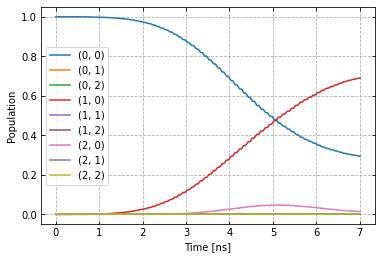

In [32]:
exp.plot_dynamics(init_state, barely_a_seq, debug=True)

We can see a bad, un-optimized gate. The labels indicate qubit states in the product basis. Next we increase the number of repetitions of the same gate.

In [33]:
barely_a_seq * 10

['X90p:Id',
 'X90p:Id',
 'X90p:Id',
 'X90p:Id',
 'X90p:Id',
 'X90p:Id',
 'X90p:Id',
 'X90p:Id',
 'X90p:Id',
 'X90p:Id']

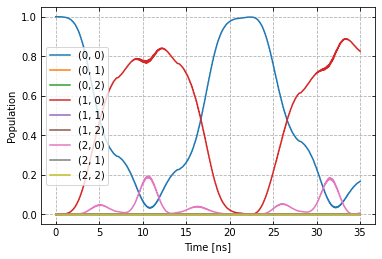

In [34]:
exp.plot_dynamics(init_state, barely_a_seq * 5, debug=True)

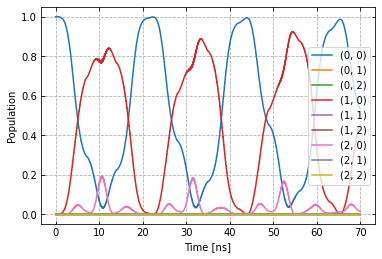

In [35]:
exp.plot_dynamics(init_state, barely_a_seq * 10, debug=True)

Note that at this point, we only multiply already computed matrices. We don't need to solve the equations of motion again for new sequences.

#### Open-loop optimal control

In order to improve the gate, we create the optimizer object for open-loop optimal control. We notice some leakage into the $|2,0>$ state and enable a DRAG option. Details on DRAG can be found here: https://arxiv.org/abs/1809.04919 The main principle is adding a phase-shifted component proportional to the derivative of the original signal. With automatic differentiation, our AWG can perform this operation automatically for arbitrary shapes.

In [36]:
generator.devices['awg'].options = 'drag_2'

At the moment there are two implementations of DRAG, variant 2 is independent of the AWG resolution.

To define which parameters we optimize, we write the gateset_opt_map, a nested list of tuples that identifies each parameter.

In [37]:
opt_gates = ["X90p:Id"]
gateset_opt_map=[
    [
      ("X90p:Id", "d1", "gauss", "amp"),
    ],
    [
      ("X90p:Id", "d1", "gauss", "freq_offset"),
    ],
    [
      ("X90p:Id", "d1", "gauss", "xy_angle"),
    ],
    [
      ("X90p:Id", "d1", "gauss", "delta"),
    ]
]

We can look at the two parameters this opt_map specified with

In [38]:
exp.gateset.get_parameters(gateset_opt_map)

[<tf.Tensor: shape=(), dtype=float64, numpy=0.5>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-333008821.28051805>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-4.440892098500626e-16>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.0>]

More human friendly output is generated by

In [39]:
print(exp.gateset.print_parameters(gateset_opt_map))

X90p:Id-d1-gauss-amp        : 500.000 mV 
X90p:Id-d1-gauss-freq_offset: -53.000 MHz 2pi 
X90p:Id-d1-gauss-xy_angle   : -444.089 arad 
X90p:Id-d1-gauss-delta      : 0.000  



In [40]:
from c3po.optimizers.c1 import C1

The C1 object will handle the optimization for us. As a fidelity function we choose average fidelity as well as LBFG-S (a wrapper of the scipy implementation) from our library. See those libraries for how these functions are defined and how to supply your own, if necessary.

In [41]:
opt = C1(
    dir_path="/tmp/c3log/",
    fid_func=fidelities.average_infid_set,
    fid_subspace=["Q1", "Q2"],
    gateset_opt_map=gateset_opt_map,
    opt_gates=opt_gates,
    algorithm=algorithms.lbfgs,
    options={"maxfun" : 10},
    run_name="better_X90"
)

Finally we supply our defined experiment.

In [42]:
opt.set_exp(exp)

Everything is in place to start the optimization.

<Figure size 432x288 with 0 Axes>

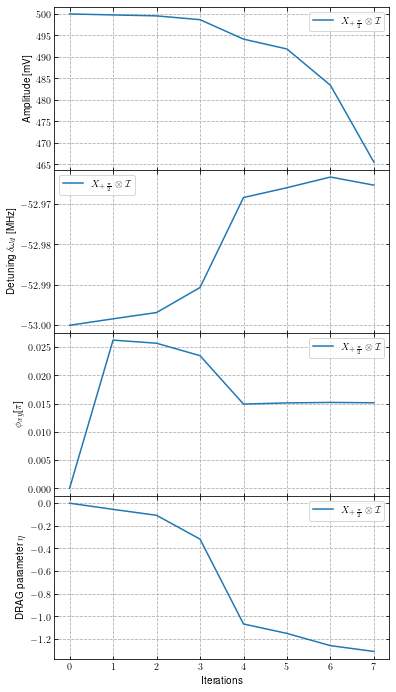

<Figure size 432x288 with 0 Axes>

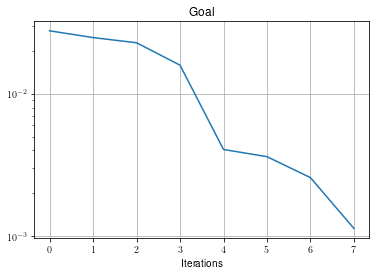

<Figure size 432x288 with 0 Axes>

In [43]:
opt.optimize_controls()

After a few steps we have improved the gate significantly, as we can check with

In [44]:
opt.current_best_goal

0.0006394 

And by looking at the same sequences as before.

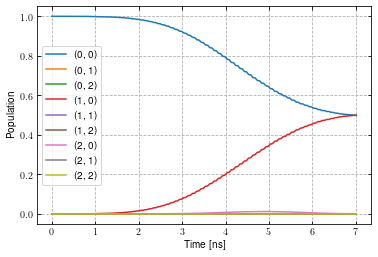

In [45]:
exp.plot_dynamics(init_state, barely_a_seq, debug=True)

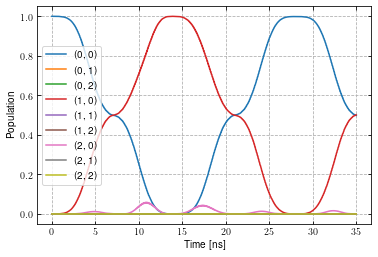

In [46]:
exp.plot_dynamics(init_state, barely_a_seq * 5, debug=True)